# Nepal Earthquake

From: [Kaggle Nepal Earthquake](https://www.kaggle.com/datasets/imtkaggleteam/nepal-earthquake)

### Context
The Nepal Earthquake Severity Index is designed to provide an overview of estimated severity of impacts resulting from the earthquake of 25 April 2015. It is not a replacement for first hand damage and needs assessment information, but can support prioritisation during early stages of the response. It estimates severity based on: 1) the intensity of the earthquake; 2) population; 3) vulnerability of housing and population. This index will be updated to take account of: validation against first hand reports and improvements to the severity model; improved sources of data (quality, timeliness and scale); changing requirements as the response continues. 

In [16]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

In [17]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.3.x

1.3.0


### Utility Functions

In [18]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [19]:
DATA = Path("data")    # Change to your data folder
assert DATA.exists()

In [20]:
eq_raw_df = pd.read_csv(DATA / "nepal-earthquake-severity-index-latest.csv", 
                        low_memory=False)

In [21]:
eq_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   P_CODE               3985 non-null   object 
 1   VDC_NAME             3985 non-null   object 
 2   DISTRICT             3985 non-null   object 
 3   REGION               3985 non-null   object 
 4   Hazard (Intensity)   3985 non-null   float64
 5   Exposure             3985 non-null   float64
 6   Housing              3985 non-null   float64
 7   Poverty              3985 non-null   float64
 8   Vulnerability        3985 non-null   float64
 9   Severity             3985 non-null   float64
 10  Severity Normalized  3985 non-null   float64
 11  Severity category    3985 non-null   object 
dtypes: float64(7), object(5)
memory usage: 373.8+ KB


In [22]:
# Drop
eq_df = eq_raw_df.iloc[:, 3:].copy()
del eq_raw_df
eq_df

,REGION,Hazard (Intensity),Exposure,Housing,Poverty,Vulnerability,Severity,Severity Normalized,Severity category
0,Central,2.17,10.00,8.86,1.82,5.34,4.88,10.0000,Highest
1,Central,1.72,2.26,8.40,0.82,4.61,2.62,5.3707,Highest
2,Central,2.21,1.47,5.38,2.53,3.96,2.34,4.8083,Highest
3,Central,2.45,0.85,8.23,0.89,4.56,2.12,4.3447,Highest
4,Central,1.91,0.87,8.86,1.82,5.34,2.07,4.2407,Highest
...,...,...,...,...,...,...,...,...,...
3981,Far-Western,0.00,0.00,8.77,8.26,8.52,0.00,0.0000,Lowest
3982,Mid-Western,0.00,0.00,4.64,4.82,4.73,0.00,0.0000,Lowest
3983,Western,0.84,0.00,5.61,3.51,4.56,0.00,0.0000,Lowest
3984,Western,0.02,0.00,7.81,2.95,5.38,0.00,0.0000,Lowest


In [23]:
# Drop the missing values
eq_df.dropna(axis="index", inplace=True)
eq_df.reset_index(drop=True, inplace=True)
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   REGION               3985 non-null   object 
 1   Hazard (Intensity)   3985 non-null   float64
 2   Exposure             3985 non-null   float64
 3   Housing              3985 non-null   float64
 4   Poverty              3985 non-null   float64
 5   Vulnerability        3985 non-null   float64
 6   Severity             3985 non-null   float64
 7   Severity Normalized  3985 non-null   float64
 8   Severity category    3985 non-null   object 
dtypes: float64(7), object(2)
memory usage: 280.3+ KB


In [24]:
#sns.pairplot(eq_df.iloc[:, [1,2,3,4,5,6,7]])
#plt.show

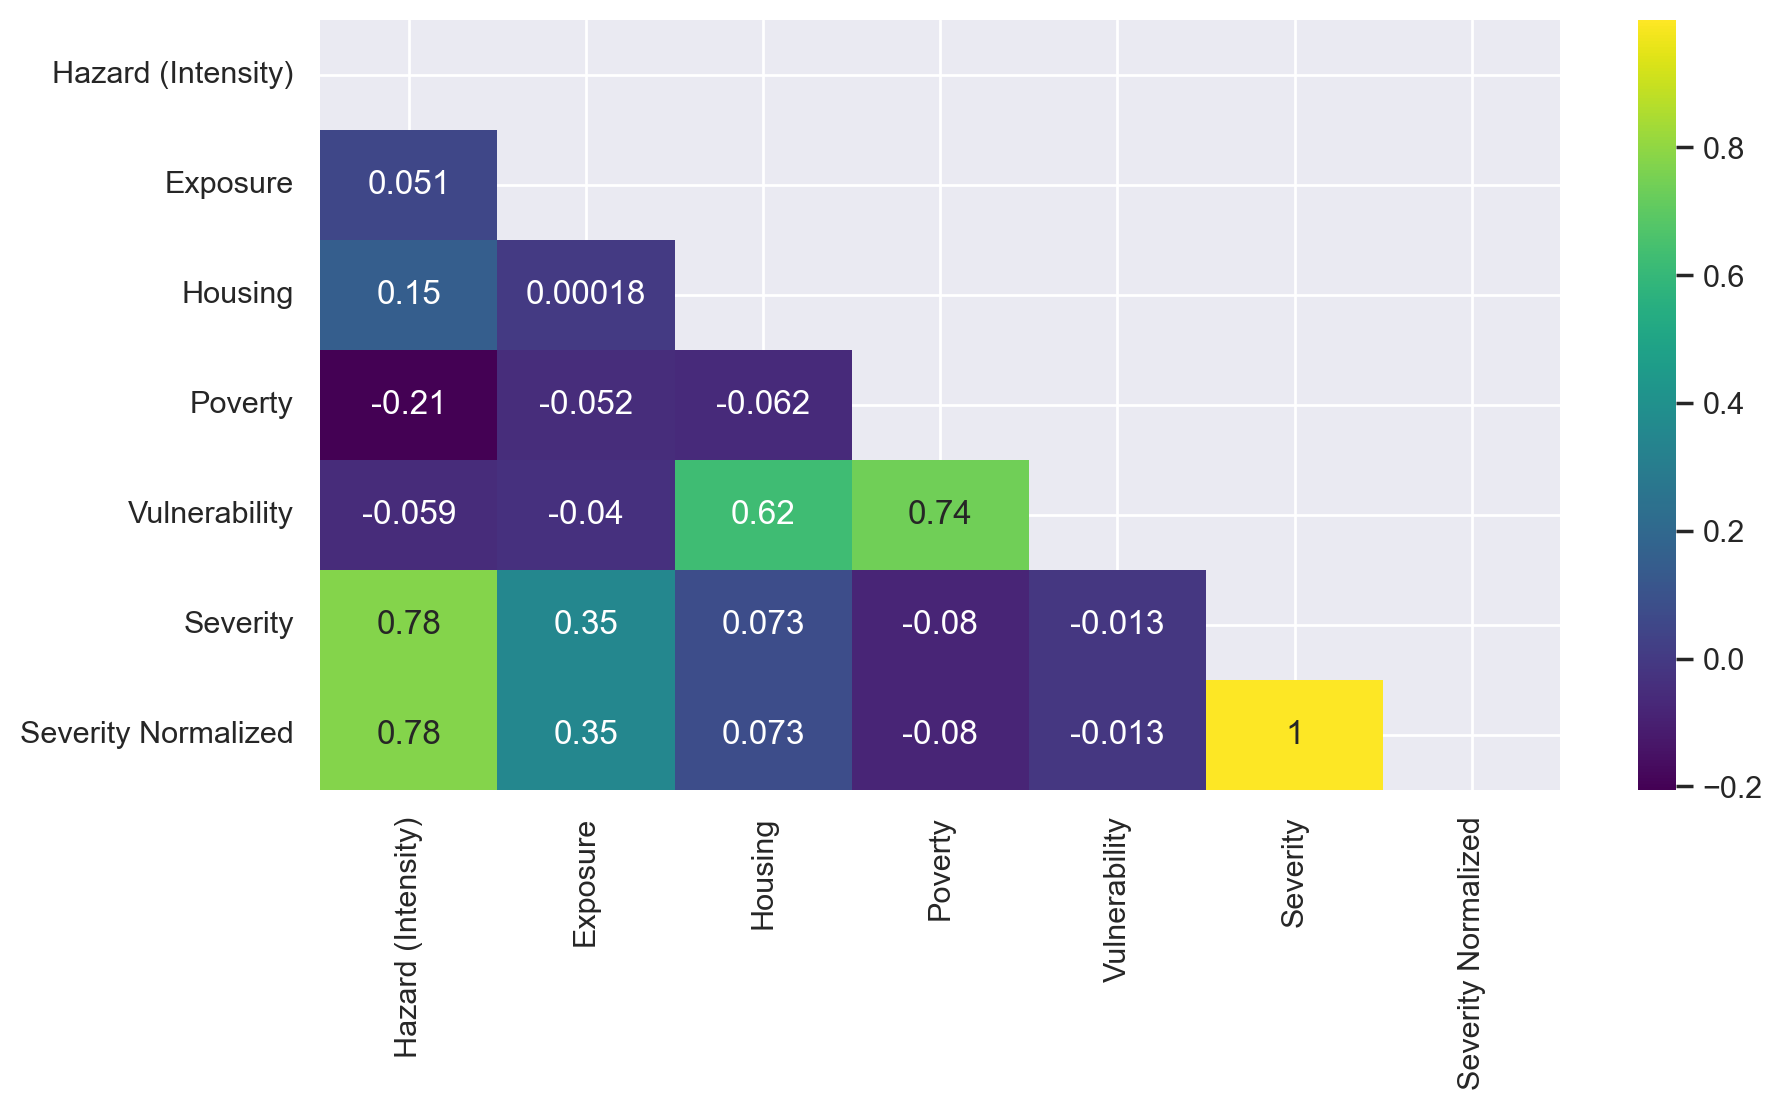

In [25]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(eq_df.corr(numeric_only=True), dtype=bool))
ax = sns.heatmap(
    eq_df.corr(numeric_only=True),
    cbar=True,
    annot=True,
    cmap="viridis",
    mask=mask,
)

In [26]:
print(eq_df.describe())
print(eq_df.describe(include='object'))

       Hazard (Intensity)     Exposure      Housing      Poverty  \
count         3985.000000  3985.000000  3985.000000  3985.000000   
mean             0.320537     0.067493     5.706522     5.481854   
std              0.779937     0.187551     1.953037     2.270975   
min              0.000000     0.000000     1.170000     0.000000   
25%              0.000000     0.030000     4.640000     3.330000   
50%              0.010000     0.050000     5.610000     5.620000   
75%              0.130000     0.070000     6.850000     7.350000   
max             10.000000    10.000000     9.940000    10.000000   

       Vulnerability     Severity  Severity Normalized  
count    3985.000000  3985.000000          3985.000000  
mean        5.594635     0.248720             0.510221  
std         1.450817     0.298756             0.612652  
min         1.620000     0.000000             0.000000  
25%         4.590000     0.050000             0.094100  
50%         5.550000     0.140000            

In [27]:
eq_df.columns

Index(['REGION', 'Hazard (Intensity)', 'Exposure', 'Housing', 'Poverty',
       'Vulnerability', 'Severity', 'Severity Normalized',
       'Severity category'],
      dtype='object')

In [28]:
# perform one-hot encoding on categorical features
categorical_features = ['REGION']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(eq_df[categorical_features])
df_features_encoded = pd.DataFrame(enc.transform(eq_df[categorical_features]).toarray(), columns=enc.get_feature_names_out())
# combine the one-hot encoded features with the numerical features
eq_df = pd.concat([eq_df.drop(categorical_features, axis=1), df_features_encoded ], axis=1)
eq_df

,Hazard (Intensity),Exposure,Housing,Poverty,Vulnerability,Severity,Severity Normalized,Severity category,REGION_Central,REGION_Eastern,REGION_Far-Western,REGION_Mid-Western,REGION_Western
0,2.17,10.00,8.86,1.82,5.34,4.88,10.0000,Highest,1.0,0.0,0.0,0.0,0.0
1,1.72,2.26,8.40,0.82,4.61,2.62,5.3707,Highest,1.0,0.0,0.0,0.0,0.0
2,2.21,1.47,5.38,2.53,3.96,2.34,4.8083,Highest,1.0,0.0,0.0,0.0,0.0
3,2.45,0.85,8.23,0.89,4.56,2.12,4.3447,Highest,1.0,0.0,0.0,0.0,0.0
4,1.91,0.87,8.86,1.82,5.34,2.07,4.2407,Highest,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980,0.00,0.00,8.45,9.21,8.83,0.00,0.0000,Lowest,0.0,0.0,1.0,0.0,0.0
3981,0.00,0.00,8.77,8.26,8.52,0.00,0.0000,Lowest,0.0,0.0,1.0,0.0,0.0
3982,0.00,0.00,4.64,4.82,4.73,0.00,0.0000,Lowest,0.0,0.0,0.0,1.0,0.0
3983,0.84,0.00,5.61,3.51,4.56,0.00,0.0000,Lowest,0.0,0.0,0.0,0.0,1.0


In [29]:
eq_df.columns

Index(['Hazard (Intensity)', 'Exposure', 'Housing', 'Poverty', 'Vulnerability',
       'Severity', 'Severity Normalized', 'Severity category',
       'REGION_Central', 'REGION_Eastern', 'REGION_Far-Western',
       'REGION_Mid-Western', 'REGION_Western'],
      dtype='object')

In [36]:
severity_mapping = {
    "Lowest" : 0,
    "Low" : 1,
    "Medium-Low" : 2,
    "Medium-High" : 3,
    "High" : 4,
    "Highest" : 5
}
eq_df['Severity category'] = eq_df['Severity category'].map(severity_mapping)
eq_df
    

,Hazard (Intensity),Exposure,Housing,Poverty,Vulnerability,Severity,Severity Normalized,Severity category,REGION_Central,REGION_Eastern,REGION_Far-Western,REGION_Mid-Western,REGION_Western
0,2.17,10.00,8.86,1.82,5.34,4.88,10.0000,5,1.0,0.0,0.0,0.0,0.0
1,1.72,2.26,8.40,0.82,4.61,2.62,5.3707,5,1.0,0.0,0.0,0.0,0.0
2,2.21,1.47,5.38,2.53,3.96,2.34,4.8083,5,1.0,0.0,0.0,0.0,0.0
3,2.45,0.85,8.23,0.89,4.56,2.12,4.3447,5,1.0,0.0,0.0,0.0,0.0
4,1.91,0.87,8.86,1.82,5.34,2.07,4.2407,5,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980,0.00,0.00,8.45,9.21,8.83,0.00,0.0000,0,0.0,0.0,1.0,0.0,0.0
3981,0.00,0.00,8.77,8.26,8.52,0.00,0.0000,0,0.0,0.0,1.0,0.0,0.0
3982,0.00,0.00,4.64,4.82,4.73,0.00,0.0000,0,0.0,0.0,0.0,1.0,0.0
3983,0.84,0.00,5.61,3.51,4.56,0.00,0.0000,0,0.0,0.0,0.0,0.0,1.0
